## Try-outs for cell counting - *Euglena*

The main goal is a system for algae counting in a microscope image. To reach this, we have some short tasks, as 1) figure upload, 2) determine what a single cell is, and 3) count. Ok, should be fair easy! :)

Here are some interesting reading (also because this example was based on *scikit-image* package tutorials):

http://scikit-image.org/docs/stable/auto_examples/index.html

https://github.com/brikeats/Image-Analysis-in-Python/blob/master/Intro%20to%20Image%20Analysis%20in%20Python.ipynb

### Counting algae - microscopy

Counting algae cells in a microscope image may sounds archaic, but still is one of the main parameters for microalgae analysis, from ecotoxicology tests to integral environment evaluations. In any way, it usually is one of the most sad and morous tasks one has to accomplish in algae research. This is due to the number of samples, or to the number of cells that has to be count in each sample - and that is on statistics. Imagine staying seated, on microscope, counting single-celled algae for 8 hours a day, for 2 weeks. No, it isn't difficult, but it brings inherently, two major problems: tiredness-related errors because of the human (lack of) plasticity, and it is time-consuming.

Therefore, algae researchers urge for automatization, and the easiest way is processing the images taken from a microscope.

For this try-out I'll use images from *Haematococcus pluvialis* and *Euglena mutabilis*, both strains are mantained and used in research at the Phycology Lab at Federal University of Santa Catarina (UFSC).

(you'll only find one algae here, the other is in the other notebook, ok? Just go back to the repo and find the hpl_rev jupyter notebook).

### Algae background

*Euglena mutabilis* (EMU): Our EMU is an acidophilic strain sampled and isolated from a mining region in Criciúma - Santa Catarina in 2010. An Euglenophyceae, the species is 70-170 μm long and 25-36 μm wide, with cylindrical body and posterial tapering, many fusiform chloroplasts and it's nucleus is posterior. This strain can thrive in pH as low as 1 and as high as 10, with optimal pH at 3.6. Our reserch on EMU shows its potential for biotechnological solutions for Heavy Metal (HM) and iron remediation, very common contaminants in mining regions.


### Basic fluxogram

Pre-treatment:
- Load image
- Gray scale
- Gaussian filter
- Threshold for binarization

Morphological operations:
- Small objects removal
- Find local maxima

Rework:
- Centroids
- Clusters

#### Cutting image and re-evaluating the dark border

I'm going to show two different images here: the original, which should be a fair example, BUT as the steps go, the dark borders get in the way. So I present the cut_example, and yes, it is a little cheating. Promise I am working on it...

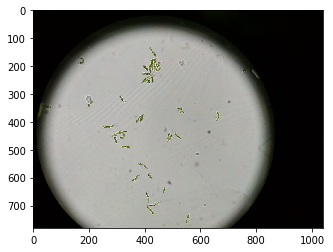

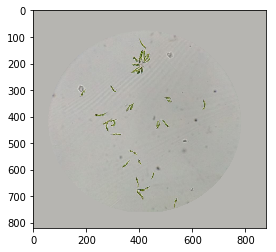

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

im_full = plt.imread('images/counting_algae_3.jpeg')

im = plt.imread('images/counting_algae_3_cut.png')

plt.figure()
plt.imshow(im_full)
plt.figure()
plt.imshow(im)

# we have two images here because im_full is the original, and should be a fair example, BUT as the steps go, the dark borders get in the way
# yes, it is a little cheating. Promise I am working on it...

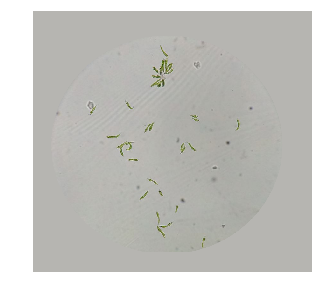

In [2]:
# defining parameters for imshow

def my_imshow(im, title=None, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    plt.figure(figsize=(5,5))
    plt.imshow(im, interpolation='none', **kwargs)
    if title:
        plt.title(title)
    plt.axis('off')

#print ('original image shape: {}'.format(im.shape))

my_imshow(im)

First, convert from color (4 channel, actually) to grayscale.

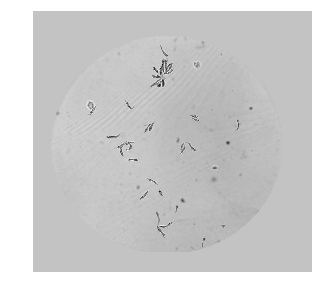

In [3]:
from skimage import color

# convert to gray 

gray_im = color.rgb2gray(im)

#print ('grayscale image shape:', gray_im.shape)

my_imshow(gray_im)


/home/gabiitokazu/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


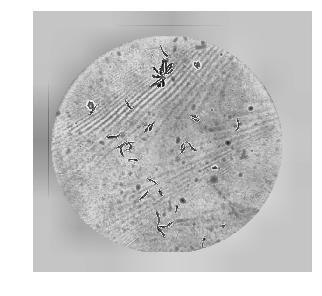

In [4]:
# setting the adaptative histogram, to spread out the most frequent intensity values
# roughly, it is a contrast adjustment

from skimage import exposure

img_eq = exposure.equalize_adapthist(gray_im, clip_limit=0.03)

my_imshow(img_eq)

The error here just states that the histogram will change dtype (from float64 to uint16), which could cause losses. We'll be fine, though.

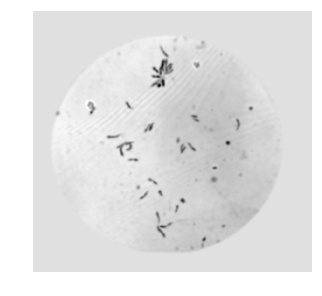

In [5]:
# blur to reduce noise using a gaussian filter

from skimage import filters
blurred_im = filters.gaussian(gray_im, sigma=3)
my_imshow(blurred_im)

Pre-processing finished, we can threshold it to convert it to a cell mask.
This will have an binary output, which will be important for our next steps.

This is the first piece of code that it will visually make sense. And because of that, here we can start to play with it.

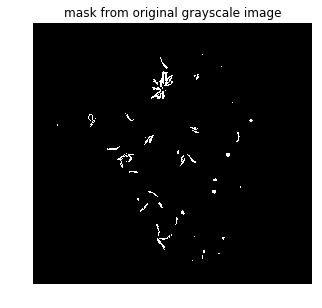

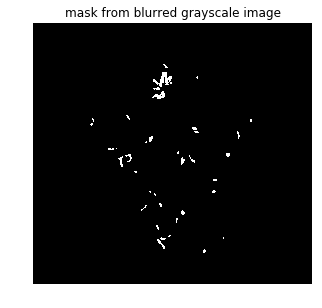

In [6]:
thresh = 0.6

# for example, go and try to change the thresh parameter.

mask = gray_im < thresh
blurred_mask = blurred_im < thresh

my_imshow(mask, title='mask from original grayscale image')
my_imshow(blurred_mask, title='mask from blurred grayscale image')

Binary images can be manipulated with morphological operations. Morphological operations allow us to expand or shrink the white regions, fill in holes, and more. In this case, we simply want to remove the tiny dots.

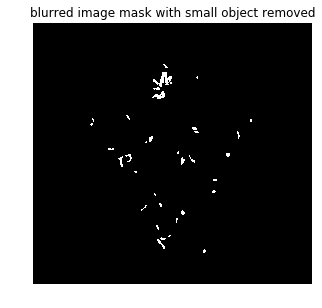

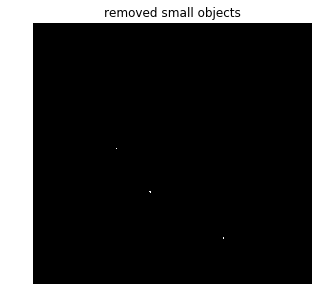

In [7]:
# this step is set according to the image per se, because each algae has a different size and shape
# do not forget that the minsize states for pixel area, it doesn't care if it's a line or a sphere, for example

from skimage import morphology

# again, we can play with the algae_minsize parameter

algae_minsize = 30
blurred_mask_clean = morphology.remove_small_objects(blurred_mask, min_size=algae_minsize)

my_imshow(blurred_mask_clean, title='blurred image mask with small object removed')
my_imshow(blurred_mask ^ blurred_mask_clean, 'removed small objects')

The next step will be to find local peaks in the image.

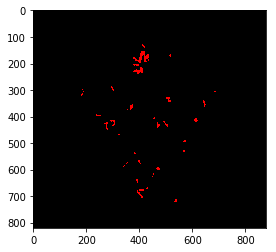

In [8]:
from skimage import feature, measure
from matplotlib.colors import ListedColormap

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


peaks_im = feature.peak_local_max(blurred_mask_clean, indices=False)

imshow_overlay(blurred_mask_clean, peaks_im, alpha=1, cmap='gray')

Now we need to cluster!

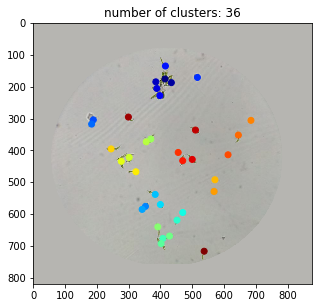

In [10]:
import scipy.cluster.hierarchy as hcluster

# clustering
thresh = 10

markers_im = measure.label(peaks_im)

properties = measure.regionprops(markers_im)
algae_areas = [int(prop.area) for prop in properties]
algae_centroids = [prop.centroid for prop in properties]

clusters = hcluster.fclusterdata(algae_centroids, thresh, criterion="distance")

algae_array = np.asarray(algae_centroids)
algae_array[:,0]


plt.figure(figsize=(5,5))
plt.imshow(im, interpolation='none', cmap='jet')
plt.scatter(algae_array[:,1], algae_array[:,0], c=clusters, cmap='jet')

#title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters)))
title = "number of clusters: %d" % (len(clusters))

plt.title(title)
plt.show()

error, error!